In [ ]:
import gymnasium as gym
import numpy as np
import random

class tictactoe :

  def __init__(self) -> None:
      self.reset()

  def reset(self):
      self.board = np.zeros((3,3),dtype=int)
      self.done = False
      self.winner = None
      return self.board, {}

  def avai_action(self) :
      return [(r,c) for r in range(3) for c in range(3) if self.board[r,c] == 0]

  def step(self,action,player=1) :
       if self.done :
          raise ValueError("Game is already done")

       row,col = action
       if self.board[row,col] != 0 :
          raise ValueError("Invalid action")

       self.board[row,col] = player
       reward,self.done = self.check_game_status(player)
       return self.board.copy(), reward, self.done, {}

  def check_game_status(self,player) :
       b =  self.board # Removed ()
       for i in range(3) :
            if abs(sum(b[i, :])) == 3 or abs(sum(b[:, i])) == 3:
                return (1 if player == 1 else -1), True
       if abs(b.trace())==3 or abs(np.fliplr(b).trace())==3 :
            return (1 if player == 1 else -1), True
       if not self.avai_action() :
            return 0, True
       return 0, False

  def random_opponent(self): # Added random_opponent method
      actions = self.avai_action()
      return random.choice(actions)

  def render(self) :
        symbols = {1:'X',-1:'O',0:' '} # Changed 0 to -1 for opponent
        b = [[symbols[self.board[r,c]] for c in range(3)] for r in range(3)]
        print(f"{b[0][0]} | {b[0][1]} | {b[0][2]}")
        print("--+---+--")
        print(f"{b[1][0]} | {b[1][1]} | {b[1][2]}")
        print("--+---+--")
        print(f"{b[2][0]} | {b[2][1]} | {b[2][2]}")
        print()



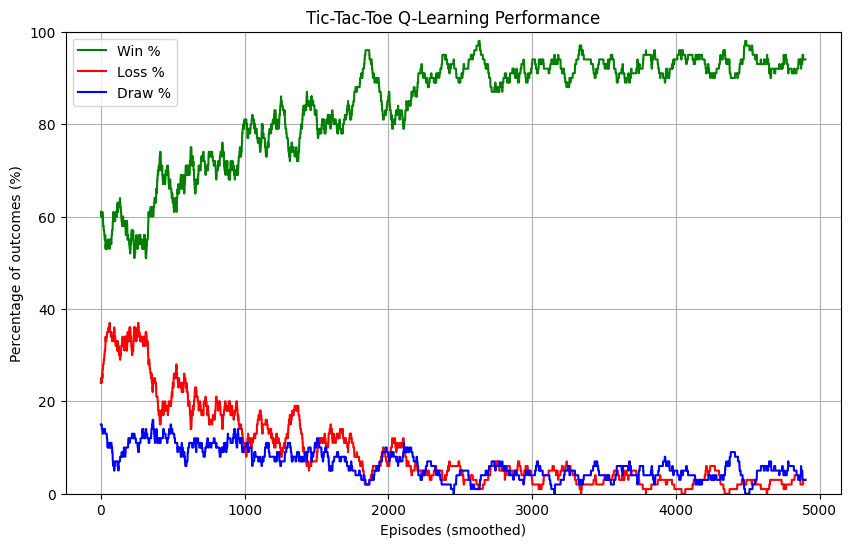

In [ ]:
from IPython.core.interactiveshell import available_events
from collections import defaultdict
import matplotlib.pyplot as plt

class Qlearning :
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(9))  # Q-table, keys are states as strings

    def state_to_key(self,state) :
        # Convert 3x3 board to a string key for Q-table
        return tuple(state.flatten())

    def choose_action(self,state) :
        # Epsilon-greedy action selection.
        key = self.state_to_key(state)
        if random.random() < self.epsilon:
            available = self.env.avai_action()
            return available[np.random.choice(len(available))]

        q_values = self.Q[key].copy()

        # Mask invalid actions
        for i in range(9) :
            row,col = divmod(i,3)
            if state[row,col] != 0 :
                q_values[i] = -np.inf
        action_idx = np.argmax(q_values)
        return divmod(action_idx, 3)

    def learn(self, state, action, reward, next_state,done):
        key = self.state_to_key(state)
        next_key = self.state_to_key(next_state)
        action_idx = action[0] * 3 + action[1]
        max_next_q = 0 if done else np.max(self.Q[next_key])
        self.Q[key][action_idx] += self.alpha * (reward + self.gamma * max_next_q - self.Q[key][action_idx])


env = tictactoe()
epsilon_start = 1.0
epsilon_end = 0.05
decay_rate = 0.999
epsilon = epsilon_start
agent = Qlearning(env, alpha=0.1, gamma=0.9, epsilon=epsilon)


episodes = 5000

win_history = []
loss_history = []
draw_history = []

for ep in range(episodes):
    agent.epsilon = epsilon
    state, _ = env.reset()
    done = False
    while not done:
        # Agent action
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action, player=1)

        if not done:
            # Opponent random move
            opp_action = env.random_opponent()
            next_state, opp_reward, done, _ = env.step(opp_action, player=-1)
            if done:
                reward = -1  # If opponent wins
            else:
                reward = 0  # Ongoing game
        # Update Q-table
        agent.learn(state, action, reward, next_state, done)
        state = next_state

    # Update stats after episode
    if reward == 1:
        win_history.append(1)
        loss_history.append(0)
        draw_history.append(0)
    elif reward == -1:
        win_history.append(0)
        loss_history.append(1)
        draw_history.append(0)
    else:
        win_history.append(0)
        loss_history.append(0)
        draw_history.append(1)

    epsilon = max(epsilon_end, epsilon * decay_rate)

# Moving average for smoother graph
def moving_average(data, window=100):
    return np.convolve(data, np.ones(window)/window, mode='valid')

# Convert to percentages
win_rate = moving_average(win_history) * 100
loss_rate = moving_average(loss_history) * 100
draw_rate = moving_average(draw_history) * 100

plt.figure(figsize=(10,6))
plt.plot(win_rate, label='Win %', color='green')
plt.plot(loss_rate, label='Loss %', color='red')
plt.plot(draw_rate, label='Draw %', color='blue')
plt.xlabel('Episodes (smoothed)')
plt.ylabel('Percentage of outcomes (%)')
plt.title('Tic-Tac-Toe Q-Learning Performance')
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.show()





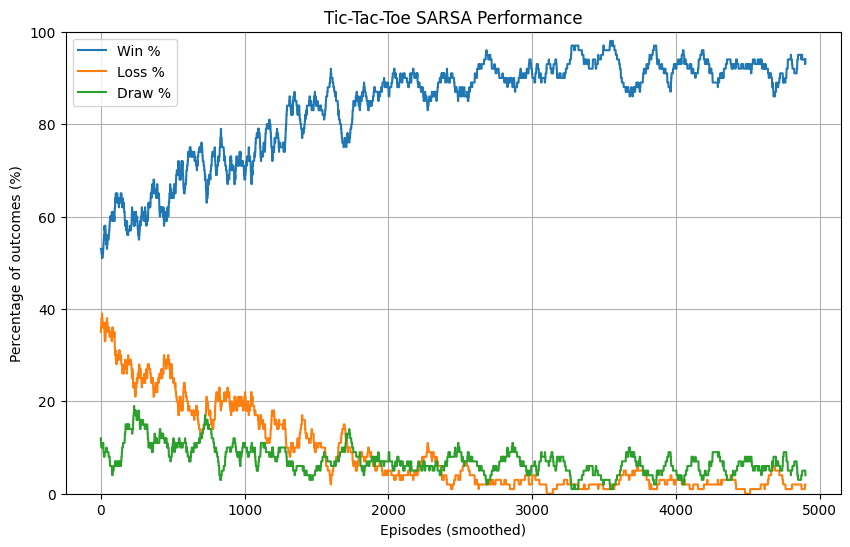

In [ ]:
from IPython.core.interactiveshell import available_events
from collections import defaultdict
import numpy as np
import random
import matplotlib.pyplot as plt

class SARSA:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(9))

    def state_to_key(self, state):
        return tuple(state.flatten())

    def choose_action(self, state):
        key = self.state_to_key(state)
        if random.random() < self.epsilon:
            available = self.env.avai_action()
            return available[np.random.choice(len(available))]

        q_values = self.Q[key].copy()
        for i in range(9):
            r, c = divmod(i, 3)
            if state[r, c] != 0:
                q_values[i] = -np.inf
        action_idx = np.argmax(q_values)
        return divmod(action_idx, 3)

    def learn(self, state, action, reward, next_state, next_action, done):
        key = self.state_to_key(state)
        next_key = self.state_to_key(next_state)
        action_idx = action[0] * 3 + action[1]
        next_idx = next_action[0] * 3 + next_action[1] if next_action is not None else None

        target = reward if done else reward + self.gamma * self.Q[next_key][next_idx]
        self.Q[key][action_idx] += self.alpha * (target - self.Q[key][action_idx])


env = tictactoe()
epsilon_start = 1.0
epsilon_end = 0.05
decay_rate = 0.999
epsilon = epsilon_start
agent = SARSA(env, alpha=0.1, gamma=0.9, epsilon=epsilon)

episodes = 5000
win_history = []
loss_history = []
draw_history = []

for ep in range(episodes):
    agent.epsilon = epsilon
    state, _ = env.reset()
    action = agent.choose_action(state)
    done = False

    while not done:
        next_state, reward, done, _ = env.step(action, player=1)

        if not done:
            opp_action = env.random_opponent()
            next_state, opp_reward, done, _ = env.step(opp_action, player=-1)
            if done:
                reward = -1
            else:
                reward = 0

        next_action = None if done else agent.choose_action(next_state)
        agent.learn(state, action, reward, next_state, next_action, done)

        state = next_state
        action = next_action

    if reward == 1:
        win_history.append(1)
        loss_history.append(0)
        draw_history.append(0)
    elif reward == -1:
        win_history.append(0)
        loss_history.append(1)
        draw_history.append(0)
    else:
        win_history.append(0)
        loss_history.append(0)
        draw_history.append(1)

    epsilon = max(epsilon_end, epsilon * decay_rate)


def moving_average(data, window=100):
    return np.convolve(data, np.ones(window) / window, mode='valid')

win_rate = moving_average(win_history) * 100
loss_rate = moving_average(loss_history) * 100
draw_rate = moving_average(draw_history) * 100

plt.figure(figsize=(10, 6))
plt.plot(win_rate, label='Win %')
plt.plot(loss_rate, label='Loss %')
plt.plot(draw_rate, label='Draw %')
plt.xlabel('Episodes (smoothed)')
plt.ylabel('Percentage of outcomes (%)')
plt.title('Tic-Tac-Toe SARSA Performance')
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.show()
